In [1]:
from _utils import *
from scipy.stats import qmc
import kmedoids
from sklearn.metrics.pairwise import euclidean_distances

def calculate_conformational_variance_jax(dmap_list, dmap_ref):
    """
    Calculate the conformational variation of a set of distance maps relative to a reference map.

    Parameters:
    dmap_list (list): A list of 2D numpy arrays representing the distance maps.
    dmap_ref (np.ndarray): A 2D numpy array representing the reference distance map.
    num_probes (int): The number of probes in the distance maps.

    Returns:
    np.ndarray: A 2D numpy array containing the variance of the squared Euclidean distances 
               between each distance map and the reference map.
    """
    # Convert dmap_list to a NumPy array
    dmap_list = jnp.array(dmap_list)
    
    # Calculate the squared Euclidean distance between each distance map and the reference map
    diff_list = jnp.sqrt((dmap_list - dmap_ref) ** 2) 
    
    # Calculate the variance along the number of observation/cell dimension
    var = jnp.var(diff_list, axis=0)
    
    return var


# Rewrite this in a jax-compatible fashion
from functools import partial
@partial(jax.jit, static_argnums=(2,)) 
def batch_calculate_variances(dmap_list, dmap_ref, num_probes):
    """
    Vectorized version that applies calculate_conformational_variance_jax across a batch of distance maps.
    """
    return jax.vmap(lambda dmap: calculate_conformational_variance_jax(dmap_list, jnp.reshape(dmap, [num_probes, num_probes])))(dmap_ref)


# Define the main loglikelihood function using JAX
def loglikelihood_jax(dmap_flat, ref_dmap_flat, measurement_error, num_probes):
    return jnp.sum(_loglikelihood_jax(dmap_flat, ref_dmap_flat, measurement_error, num_probes))


# Define the helper function, with JAX-compatible logic
def _loglikelihood_jax(dmap_flat, ref_dmap_flat, measurement_error, num_probes):
    # Use lax.cond for control flow based on the condition
    min_value = jnp.iinfo(jnp.int32).min
    
    def handle_invalid_reference(ref_dmap_flat):
        # Return extremely low probability when ref_dmap_flat contains invalid values
        return jnp.array([jnp.float32(min_value), jnp.float32(min_value)])
    
    def handle_valid_reference(ref_dmap_flat):
        # Calculate the difference between distance map and reference 
        subtraction_map_sq = jnp.square(dmap_flat - ref_dmap_flat).reshape(num_probes, num_probes)

        # Only consider the upper triangular part of the distance map
        # because the diagonal values do not have variance
        triu_indices = jnp.triu_indices(num_probes, k=1)
        measurement_error_scaled = 2 * measurement_error[triu_indices]  # both triangles 
        subtraction_map_sq_scaled = 2 * subtraction_map_sq[triu_indices]  # both triangles
        
        # Calculate the normalization factor
        normalization_factor = -jnp.sum(jnp.log(jnp.sqrt(2 * jnp.pi * measurement_error_scaled**2)))
        
        # Calculate the Gaussian term 
        gaussian_term = -jnp.sum(subtraction_map_sq_scaled / (2 * jnp.square(measurement_error_scaled)))
        
        return jnp.array([normalization_factor, gaussian_term])

    # Apply the appropriate logic depending on whether ref_dmap_flat contains negative values
    return lax.cond(
        jnp.any(ref_dmap_flat <= -1),
        handle_invalid_reference,
        handle_valid_reference,
        ref_dmap_flat
    )
    
def compute_loglikelihood_for_y(y, templates_flatten, measurement_error_esc, num_probes):
    return jax.vmap(lambda x, z: loglikelihood_jax(y, x, z, num_probes))(templates_flatten, measurement_error_esc)


folder_path = '/mnt/home/tudomlumleart/ceph/05_Sox9Dataset/'
    
num_monomers = 80

# Load polys data and then perform linear interpolation
# List all .mat files in the folder and load them
cnc_polys = scipy.io.loadmat(folder_path + 'cncPols.mat')['cncPols'][:num_monomers, :, :]
esc_polys = scipy.io.loadmat(folder_path + 'escPols.mat')['escPols'][:num_monomers, :, :]

esc_polys_interp = interpolate_polymers(esc_polys)
cnc_polys_interp = interpolate_polymers(cnc_polys)

def calculate_distance_map(polys):
    # Extract the dimensions of the input array
    num_probes, num_coords, num_cells = polys.shape
    
    # Initialize an array of the same shape to hold the interpolated values
    new_maps = np.zeros((num_cells, num_probes, num_probes))
    
    # Iterate over each cell
    for c in range(num_cells):
        # Extract the data for the current cell
        curr_cells = polys[:, :, c]
        
        # Skip cells with all missing values
        if np.all(np.isnan(curr_cells)):
            continue  # This leaves a matrix of zeros in the output array
        
        # Calculate the pairwise Euclidean distance between each pair of probes
        dmap = squareform(pdist(curr_cells))
        
        # Assign the distance map to the corresponding position in the output array
        new_maps[c, :, :] = dmap
    
    # Return the array with interpolated values
    return new_maps

esc_maps_interp = calculate_distance_map(esc_polys_interp)
cnc_maps_interp = calculate_distance_map(cnc_polys_interp)
esc_maps_interp_flat = np.array([x.flatten() for x in esc_maps_interp])
cnc_maps_interp_flat = np.array([x.flatten() for x in cnc_maps_interp])
all_maps_interp = np.concatenate((esc_maps_interp, cnc_maps_interp), axis=0)
all_maps_interp_flat = np.concatenate((esc_maps_interp_flat, cnc_maps_interp_flat), axis=0)

2024-10-17 17:23:49.378732: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-17 17:23:49.856309: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
pca = PCA(n_components=None)
pca.fit(all_maps_interp_flat)
esc_maps_pca = pca.transform(esc_maps_interp_flat)
cnc_maps_pca = pca.transform(cnc_maps_interp_flat)

esc_df = pd.DataFrame(esc_maps_pca, columns=[f'PC{i+1}' for i in range(esc_maps_pca.shape[1])])
esc_df['label'] = 'ESC'
cnc_df = pd.DataFrame(cnc_maps_pca, columns=[f'PC{i+1}' for i in range(esc_maps_pca.shape[1])])
cnc_df['label'] = 'CNC'
all_df = pd.concat([esc_df, cnc_df], axis=0)

In [4]:
all_df.shape

(2982, 2983)

In [6]:
sample_nums = [10, 50, 100, 250, 500, 1000, 2000]
# Randomly sample the data
sampled_data = []
for sample_num in sample_nums:
    sampled_data.append(all_df.sample(sample_num, random_state=42))

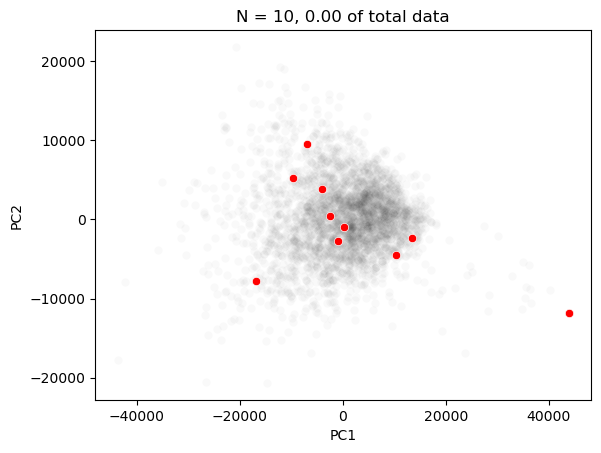

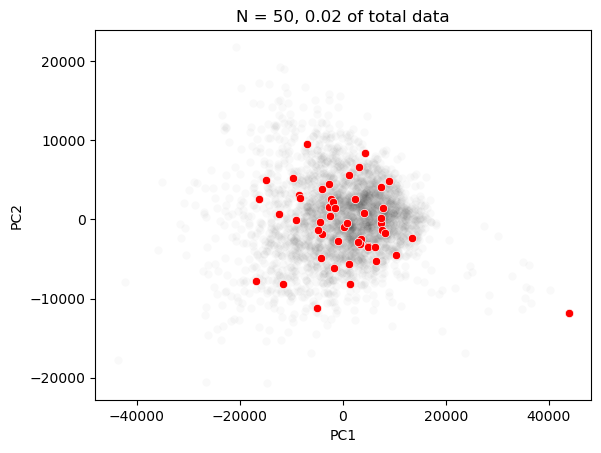

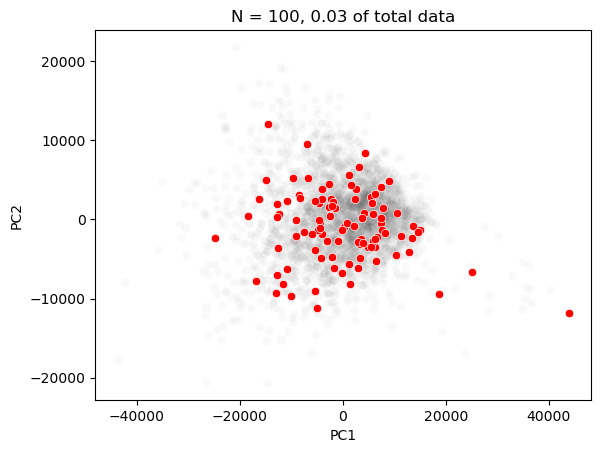

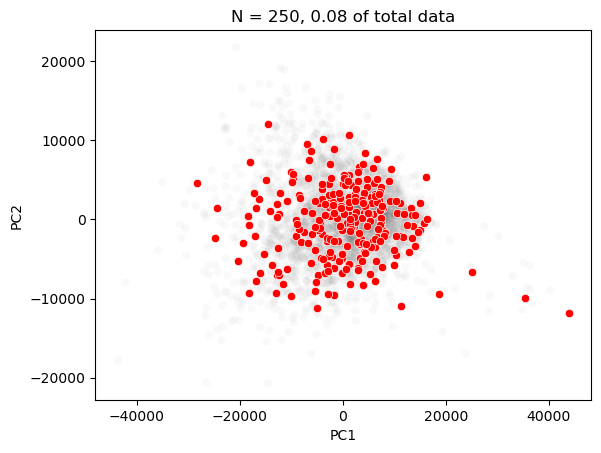

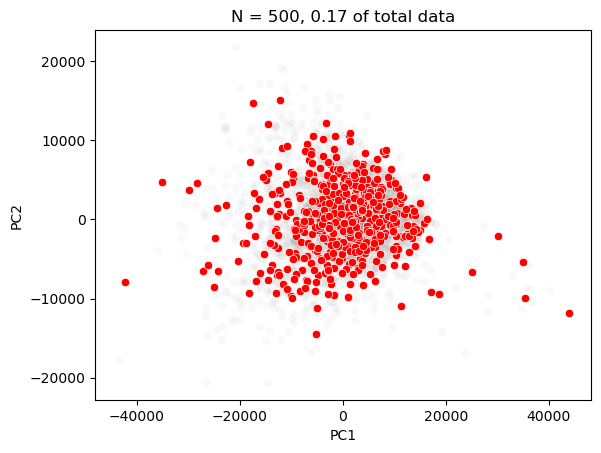

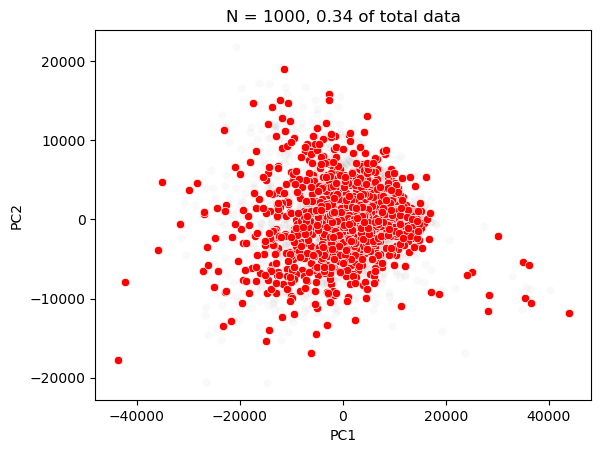

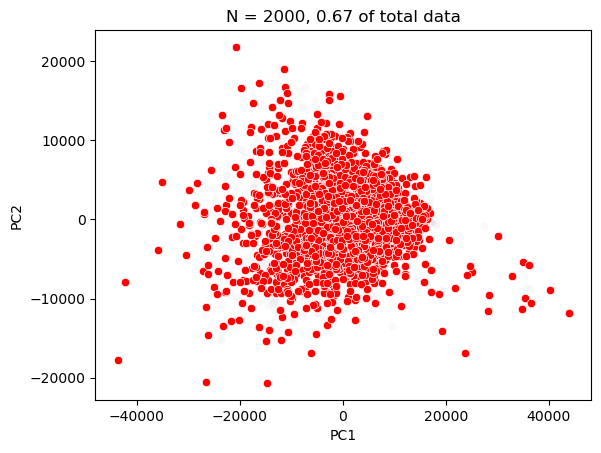

In [11]:
x_axis = 'PC1'
y_axis = 'PC2'

for i, sample_df in enumerate(sampled_data):
    sns.scatterplot(data=all_df, x=x_axis, y=y_axis, 
                    alpha=0.025, color='black', legend=False)
    sns.scatterplot(data=sample_df, x=x_axis, y=y_axis,
                color='red', legend=False)
    plt.title(f'N = {sample_nums[i]}, {sample_nums[i]/all_df.shape[0]:.2f} of total data')
    # plt.savefig(f'{save_dir}/medoids_{num_clusters[i]}_microstates_{x_axis}_{y_axis}.png')
    plt.show()